# Purity Network
Quantum Neural Network (QNN) that compute the purity of a given state

In [6]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

from state_preparation import state_preparation_network

## Constants

### Dataset

In [33]:
data_folder = "data"

n_qumodes = 2
size_system = n_qumodes * 2 # for purification
cutoff = 3
size_hilbert = cutoff**n_qumodes

ratio_train = 0.5

### Purity Network

In [3]:
n_layers_pn = 20

batch_size_pn = 16

## Loading the dataset

### Loading the files

In [7]:
rhos = np.load(os.path.join(data_folder, "rhos.npy"))
purities = np.load(os.path.join(data_folder, "purities.npy"))
list_params = np.load(os.path.join(data_folder, "list_params.npy"))

In [10]:
n_samples = len(rhos)
n_samples_train = int(ratio_train*n_samples)

### Dividing train and test

In [11]:
X_train = list_params[:n_samples_train]
X_test = list_params[n_samples_train:]

Y_train = purities[:n_samples_train]
Y_test = purities[n_samples_train:]

## State preparation procedure

### Placeholders

In [178]:
rho_params_input = tf.placeholder(tf.complex64, [None, size_hilbert, size_hilbert])
purity_input = tf.placeholder(tf.float32, [None])
lr_placeholder = tf.placeholder(tf.float32)

### Parameters

In [179]:
# Initial parameters

# squeeze gate
sp_sq_r = tf.Variable(tf.random_normal(shape=[n_layers_sp, size_system], stddev=active_std))
sp_sq_phi = tf.Variable(tf.random_normal(shape=[n_layers_sp, size_system], stddev=passive_std))

# displacement gate
sp_d_r = tf.Variable(tf.random_normal(shape=[n_layers_sp, size_system], stddev=active_std))
sp_d_phi = tf.Variable(tf.random_normal(shape=[n_layers_sp, size_system], stddev=passive_std))

# interferometer
sp_inter_theta = tf.Variable(tf.random_normal(shape=[n_layers_sp*2, int(size_system*(size_system-1)/2)], stddev=passive_std))
sp_inter_phi = tf.Variable(tf.random_normal(shape=[n_layers_sp*2, int(size_system*(size_system-1)/2)], stddev=passive_std))
sp_inter_rphi = tf.Variable(tf.random_normal(shape=[n_layers_sp*2, size_system-1], stddev=passive_std))

# kerr gate
sp_kappa = tf.Variable(tf.random_normal(shape=[n_layers_sp, size_system], stddev=active_std))

In [180]:
sp_parameters = [sp_sq_r, sp_sq_phi, sp_d_r, sp_d_phi, sp_inter_theta, sp_inter_phi, sp_inter_rphi, sp_kappa]

### Construct the circuit

In [181]:
def Interferometer(theta, phi, rphi, q):
	# parameterised interferometer acting on N qumodes
    # theta is a list of length N(N-1)/2
    # phi is a list of length N(N-1)/2
    # rphi is a list of length N-1
	# q is the list of qumodes the interferometer is to be applied to
    N = len(q)

    if N == 1:
        # the interferometer is a single rotation
        Rgate(rphi[0]) | q[0]
        return

    n = 0 # keep track of free parameters

    # Apply the Clements beamsplitter array
    # The array depth is N
    for l in range(N):
        for k, (q1, q2) in enumerate(zip(q[:-1], q[1:])):
            #skip even or odd pairs depending on layer
            if (l+k)%2 != 1:
                BSgate(theta[n], phi[n]) | (q1, q2)
                n += 1

    # apply the final local phase shifts to all modes except the last one
    for i in range(len(q)-1):
        Rgate(rphi[i]) | q[i]

In [182]:
def layer(i, q, params):
    sq_r, sq_phi, d_r, d_phi, inter_theta, inter_phi, inter_rphi, kappa = tuple(params)
    
    Interferometer(inter_theta[2*i], inter_phi[2*i], inter_rphi[2*i], q)
    
    for j in range(len(q)):
        Sgate(sq_r[i,j], sq_phi[i,j]) | q[j]
        
    Interferometer(inter_theta[2*i+1], inter_phi[2*i+1], inter_rphi[2*i+1], q)
    
    for j in range(len(q)):
        Dgate(d_r[i,j], d_phi[i,j]) | q[j]
        
    for j in range(len(q)):
        Kgate(kappa[i,j]) | q[j]

    return q

In [183]:
def state_preparation(q):
    for i in range(n_layers_sp):
        layer(i, q, sp_parameters)

In [184]:
# Start SF engine
engine, q = sf.Engine(n_qumodes*2)

# Apply circuit of layers with corresponding depth
with engine:
    state_preparation(q)

In [185]:
# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=[0,1])
reduced_dm = tf.reshape(tf.einsum('ijkl->ikjl', state.dm()), (size_hilbert, size_hilbert))

### Cost and optimizer

In [186]:
def normed_cost_function(rho1, rho2):
    return tf.reduce_mean(tf.real(tf.norm(rho1 - rho2, axis=(1,2))))

def eigen_cost_function(rho1, rho2):
    return tf.reduce_mean(tf.square(tf.real(tf.linalg.eigvalsh(rho1 - rho2))))
#     return tf.reduce_mean(tf.square(tf.real(tf.linalg.eigvalsh(rho1) - tf.linalg.eigvalsh(rho2))))

In [208]:
cost = normed_cost_function(reduced_dm, rho_input)

In [209]:
optimiser = tf.train.AdamOptimizer(learning_rate=lr_placeholder)
min_cost = optimiser.minimize(cost)

### Training

In [210]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [211]:
cost_train_list = []
cost_val_list = []
i = 0

In [243]:
nb_iters = 1000
lr = 3e-3
batch_size_sp = n_samples_train

for i in range(i, nb_iters+i):
    samples_idx = np.random.choice(n_samples_train, size=batch_size_sp, replace=False)
    X_samples_train = X_train[samples_idx]
#     X_samples_val = X_test[samples_idx]

    _, cost_train = sess.run([min_cost, cost], feed_dict={rho_input: X_samples_train, lr_placeholder: lr})
    
#     cost_val = sess.run(cost, feed_dict={rho_input: X_samples_val})
    
    cost_train_list.append(cost_train)
#     cost_val_list.append(cost_val)
    
    clear_output(wait=True)
    print('Cost after step {:5d}: {: .7f}'.format(i, cost_train_list[-1]))
i = i+1

Cost after step  3566:  0.0571850


KeyboardInterrupt: 

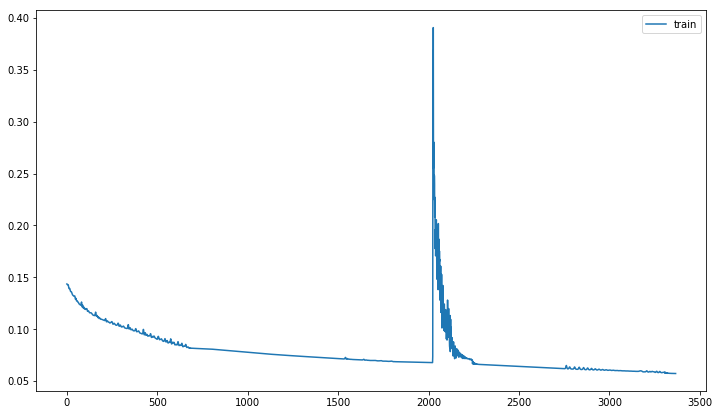

In [244]:
start = 200

plt.rcParams['figure.figsize'] = (12,7)
plt.plot(cost_train_list[start:], label="train")
plt.legend()
# plt.yscale('log')

In [245]:
pred_dm = sess.run(reduced_dm)
true_dm = X_train[0]

In [252]:
np.real(np.trace(pred_dm @ pred_dm))

0.20608966

In [251]:
np.real(np.trace(true_dm @ true_dm))

0.2458218631374422

## Purity Network

### Parameters

In [27]:
# Initial parameters

# squeeze gate
pn_sq_r = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=active_std))
pn_sq_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=passive_std))

# displacement gate
pn_d_r = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=active_std))
pn_d_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes], stddev=passive_std))

# interferometer
pn_inter_theta = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, int(n_qumodes*(n_qumodes-1)/2)], stddev=passive_std))
pn_inter_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, int(n_qumodes*(n_qumodes-1)/2)], stddev=passive_std))
pn_inter_rphi = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, n_qumodes-1], stddev=passive_std))

# kerr gate
pn_kappa = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes*2], stddev=active_std))

In [28]:
pn_parameters = [pn_sq_r, pn_sq_phi, pn_d_r, pn_d_phi, pn_inter_theta, pn_inter_phi, pn_inter_rphi, pn_kappa]

### Architecture

In [29]:
def purification_net(q):
    # First layers with same size
    for i in range(n_layers_pn - (n_qumodes-2)): # same-size layers
        layer(i, q, pn_parameters)
    
    # Progressive size reduction for the last layers
    for i in range(n_qumodes-2):
        MeasureFock() | q[i]
        l = i+(n_layers_pn - (n_qumodes-2))
        layer(l, q[i+1:], pn_parameters)
        
    # Measurement of the second-to-last qumode.
    MeasureFock() | q[n_qumodes-2]

In [30]:
with engine:
    purification_net(q[:n_qumodes])

In [31]:
# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=[n_qumodes-1], apply_history=True)

In [32]:
sess.run(tf.variables_initializer(pn_parameters))

In [33]:
purity = tf.cast(state.quad_expectation(mode=0)[0], dtype=tf.float32)

### Cost and optimizer

In [34]:
def cost_function(purity1, purity2):
    return tf.reduce_mean(tf.square(purity1 - purity2))

In [35]:
cost = cost_function(purity, purity_input)

In [36]:
optimiser = tf.train.AdamOptimizer(learning_rate=lr_placeholder)
min_cost = optimiser.minimize(cost, var_list=pn_parameters)

In [37]:
sess.run(tf.variables_initializer(optimiser.variables()))

### Training

In [38]:
cost_train_list = []
cost_val_list = []
i = 0

In [41]:
nb_iters = 300
lr = 1e-4

for i in range(i, nb_iters+i):
    samples_idx = np.random.choice(n_samples_train, size=batch_size_sp, replace=False)
    X_samples_train = X_train[samples_idx]
    X_samples_val = X_test[samples_idx]
    Y_samples_train = Y_train[samples_idx]
    Y_samples_val = Y_test[samples_idx]

    _, cost_train = sess.run([min_cost, cost], feed_dict={rho_input: X_samples_train, 
                                                          purity_input: Y_samples_train,
                                                          lr_placeholder: lr})
    
    cost_val = sess.run(cost, feed_dict={rho_input: X_samples_val, purity_input: Y_samples_val})
    
    cost_train_list.append(cost_train)
    cost_val_list.append(cost_val)
    
    clear_output(wait=True)
    print('Cost after step {:5d}: {: .7f}'.format(i, cost_train_list[-1]))
i = i+1

Cost after step   191:  0.0281371


KeyboardInterrupt: 

### Visualization and result

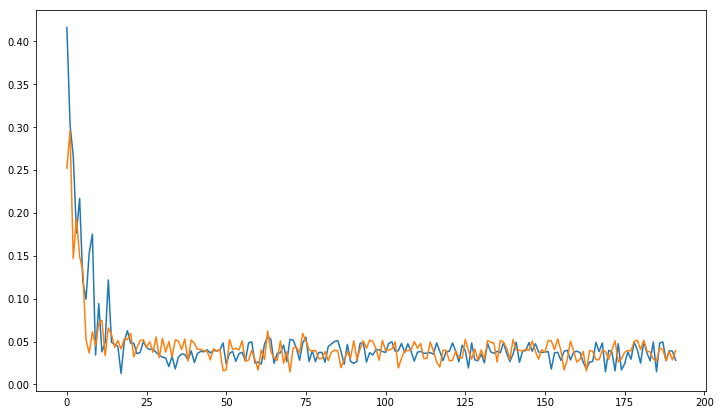

In [42]:
plt.rcParams['figure.figsize'] = (12,7)
plt.plot(cost_train_list)
plt.plot(cost_val_list)

In [63]:
j = 10
print(sess.run(purity, feed_dict={rho_input: X_samples_train[j:j+1]}))
print(Y_train[j])

0.3922874
(1-6.5052130349130266e-18j)


(0.4062200824205112-7.589415207398531e-19j)